In [12]:
import uproot
import h5py
import numpy as np
import os
import re
import awkward as awk
import pandas as pd
import heplot as hepl
from heplot import string_constants as he_stco
import matplotlib.pyplot as plt
import importlib
import glob
from heplot import plotting as heplt
import mplhep as hep
import sys
sys.path.append('..')

In [2]:
import src.selection as sele
import src.string_constants as stco
import src.generator as gene
import src.reader as read
import src.util as util

In [6]:
from heputl import logging as heplog
logger = heplog.get_logger(__name__)

# read MC and data from selection dump

In [7]:
def read_selected(sample_id:str,N:int=None) -> pd.DataFrame:

    path = os.path.join(stco.out_dir_data_selected,stco.selected_file_names_dd[sample_id])
    df = pd.read_hdf(path,'df')

    return df.iloc[:N] if N else df


# *********************************************************** #
#                    read MC & data                           #
# *********************************************************** #

N = int(1e3)

#***************************** MC *************************** #

# background
df = read_selected('bg',N)
ttb, zz, wz = util.split_into_ttbar_zz_wz(df) # ttb, zz, wz
logger.info(f'mc background read: {len(ttb)} ttb, {len(zz)} zz and {len(wz)} wz samples')

# signal
df = read_selected('sig',N)
jetU, jetC, jetB, jetT = util.split_by_jet_flavor(df)
logger.info(f'mc signal read: {len(jetU)} light, {len(jetC)} charm, {len(jetB)} B and {len(jetT)} tau jet samples')


#***************************** data ************************** #

dat = read_selected('dat',N)
logger.info(f'data read: {len(dat)} samples')

2024-06-04 12:37:09 [4060194939.py:<module>] mc background read: 100 ttb, 200 zz and 100 wz samples
2024-06-04 12:37:09 [4060194939.py:<module>] mc signal read: 630 light, 88 charm, 153 B and 0 tau jet samples
2024-06-04 12:37:09 [4060194939.py:<module>] data read: 100 samples


/tmp/kiwoznia/ipykernel_924134/2387278535.py:24: RuntimeWarning: divide by zero encountered in divide
  ax2.scatter(bins[:-1], dat_n / sum(mc_n[:-1]),color=palette[2])
/tmp/kiwoznia/ipykernel_924134/2387278535.py:24: RuntimeWarning: invalid value encountered in divide
  ax2.scatter(bins[:-1], dat_n / sum(mc_n[:-1]),color=palette[2])
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


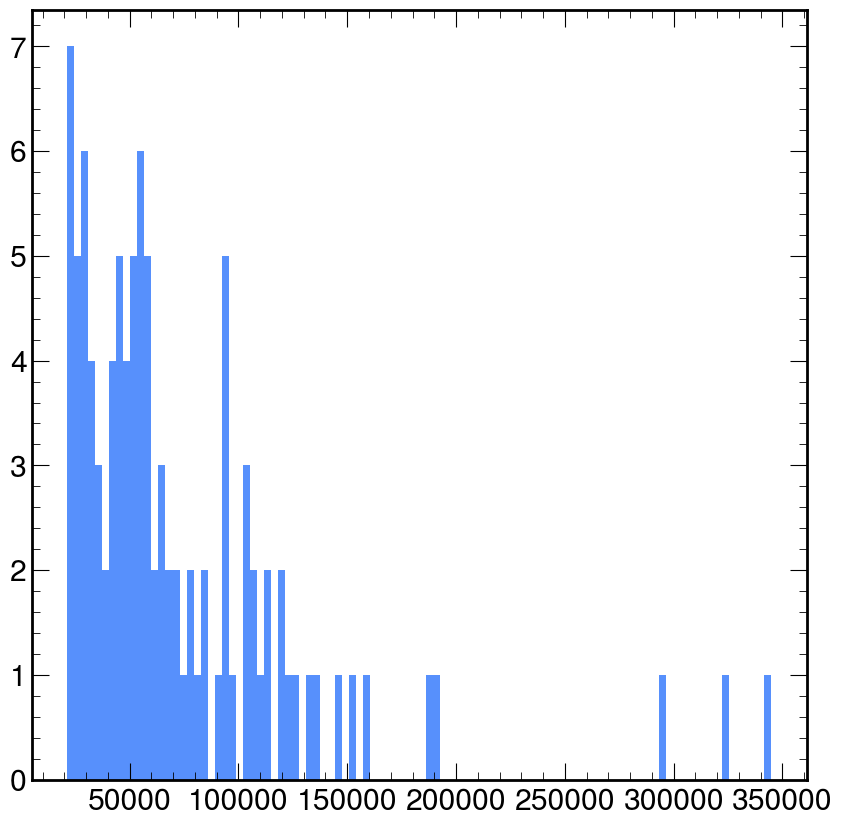

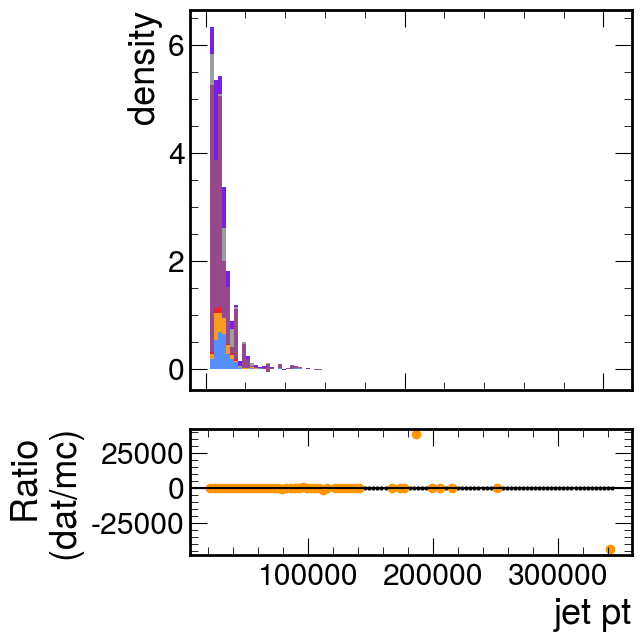

In [18]:
# *********************************************************** #
#           plot stacked histogram MC vs data                 #
# *********************************************************** #

# assemble samples to plot

values = [ttb.jet_pt_lead, zz.jet_pt_lead, wz.jet_pt_lead, jetU.jet_pt_lead, jetC.jet_pt_lead, jetB.jet_pt_lead, jetT.jet_pt_lead]
weights = [ttb.wt, zz.wt, wz.wt, jetU.wt, jetC.wt, jetB.wt, jetT.wt]
labels = ['ttb', 'zz', 'wz', 'Z + light jet', 'Z + c jet', 'Z + b jet', 'Z + tau jet']

# set plotting params
plt.style.use(hep.style.CMS)
palette=he_stco.default_palette
binN = 100

# get data bin heights
dat_n,bins,patches = plt.hist(dat.jet_pt_lead,bins=binN)

fig, (ax1, ax2) = plt.subplots(2,1,figsize=(7,7), gridspec_kw={'height_ratios': [3, 1]})

mc_n,mc_bins,patches = ax1.hist(values, weights=weights, stacked=True, label=labels, bins=binN, color=palette)
plt.scatter(bins[:-1]+ 0.5*(bins[1:] - bins[:-1]), dat_n, marker='o', c='black', s=4, alpha=1)
ratio = np.divide(sum(mc_n[:-1]), dat_n, out=np.zeros_like(dat_n), where=dat_n!=0)
ax2.scatter(bins[:-1], ratio, color=palette[2])
ax2.set_xlabel('jet pt')
#ax1.set_xlim(left=-0.8,right=3.1)
ax1.set_ylabel('density')
ax2.set_ylabel("Ratio \n (mc/dat)")
ax2.axhline(y=1., color='k', linestyle='-')
ax1.set_xticklabels([])
plt.legend()
plt.tight_layout()
plt.show()

In [17]:
sum(mc_n).shape

(100,)

In [ ]:
sample_dd = {}

for dsid, path in paths.items():

    # read samples from all files for a dsid
    samples = generate_all_evts_for_dsid(dsid, path, feat_in, feat_out, N=int(1e2))
    # compute and apply event weights
    samples['wt'] = util.compute_mc_event_weights(samples)*stco.sow_dd[dsid]
    # add to dict
    sample_dd[dsid] = samples

600 samples read for dsid 410472
600 samples read for dsid 363356
600 samples read for dsid 363358
600 samples read for dsid 364302
600 samples read for dsid 506193
600 samples read for dsid 506194


In [8]:
paths

['/eos/atlas/atlascerngroupdisk/perf-flavtag/calib/negtag/Rel24_GN2v01/Ntuples_Nominal/mc20d/user.ltoffoli.mc20_13T.410472.PhPy8EG_A14_ttbar_hdamp258p75_dil.D_FTAG2.e6348_s3681_r13144_p5981.GN2v01_Nom_output.root',
 '/eos/atlas/atlascerngroupdisk/perf-flavtag/calib/negtag/Rel24_GN2v01/Ntuples_Nominal/mc20d/user.ltoffoli.mc20_13T.363356.Sherpa_221_NNPDF30NNLO_ZqqZll.D_FTAG2.e5525_s3681_r13144_p5981.GN2v01_Nom_output.root',
 '/eos/atlas/atlascerngroupdisk/perf-flavtag/calib/negtag/Rel24_GN2v01/Ntuples_Nominal/mc20d/user.ltoffoli.mc20_13T.363358.Sherpa_221_NNPDF30NNLO_WqqZll.D_FTAG2.e5525_s3681_r13144_p5981.GN2v01_Nom_output.root',
 '/eos/atlas/atlascerngroupdisk/perf-flavtag/calib/negtag/Rel24_GN2v01/Ntuples_Nominal/mc20d/user.ltoffoli.mc20_13T.364302.Sherpa_222_NNPDF30NNLO_ggZllZqq.D_FTAG2.e6273_s3681_r13144_p5981.GN2v01_Nom_output.root',
 '/eos/atlas/atlascerngroupdisk/perf-flavtag/calib/negtag/Rel24_GN2v01/Ntuples_Nominal/mc20d/user.ltoffoli.mc20_13T.506193.MGPy8EG_Zee_FxFx_3jets_HT2b

In [9]:
stco.ds_ids_all

['410472',
 '363356',
 '363358',
 '364302',
 '506193',
 '506194',
 '506195',
 '506196',
 '506197',
 '506198',
 '512198',
 '512199',
 '512200']

In [13]:
{dsid : glob.glob(os.path.join(stco.in_dir_mc,'*'+dsid+'*'))[0] for dsid in stco.ds_ids_all}

{'410472': '/eos/atlas/atlascerngroupdisk/perf-flavtag/calib/negtag/Rel24_GN2v01/Ntuples_Nominal/mc20d/user.ltoffoli.mc20_13T.410472.PhPy8EG_A14_ttbar_hdamp258p75_dil.D_FTAG2.e6348_s3681_r13144_p5981.GN2v01_Nom_output.root',
 '363356': '/eos/atlas/atlascerngroupdisk/perf-flavtag/calib/negtag/Rel24_GN2v01/Ntuples_Nominal/mc20d/user.ltoffoli.mc20_13T.363356.Sherpa_221_NNPDF30NNLO_ZqqZll.D_FTAG2.e5525_s3681_r13144_p5981.GN2v01_Nom_output.root',
 '363358': '/eos/atlas/atlascerngroupdisk/perf-flavtag/calib/negtag/Rel24_GN2v01/Ntuples_Nominal/mc20d/user.ltoffoli.mc20_13T.363358.Sherpa_221_NNPDF30NNLO_WqqZll.D_FTAG2.e5525_s3681_r13144_p5981.GN2v01_Nom_output.root',
 '364302': '/eos/atlas/atlascerngroupdisk/perf-flavtag/calib/negtag/Rel24_GN2v01/Ntuples_Nominal/mc20d/user.ltoffoli.mc20_13T.364302.Sherpa_222_NNPDF30NNLO_ggZllZqq.D_FTAG2.e6273_s3681_r13144_p5981.GN2v01_Nom_output.root',
 '506193': '/eos/atlas/atlascerngroupdisk/perf-flavtag/calib/negtag/Rel24_GN2v01/Ntuples_Nominal/mc20d/user.lt